In [1]:
from fastai.vision import *
import pandas as pd
import zipfile
from datetime import datetime
from shutil import copyfile

In [2]:
Path = Path('data/actors')

In [3]:
Path.ls()

[PosixPath('data/actors/Test'),
 PosixPath('data/actors/test.csv'),
 PosixPath('data/actors/Submission_DN201_06102019_2354.csv'),
 PosixPath('data/actors/.ipynb_checkpoints'),
 PosixPath('data/actors/Train'),
 PosixPath('data/actors/Submission_DN161_06102019_2025.csv'),
 PosixPath('data/actors/sample_submission.csv'),
 PosixPath('data/actors/Submission_RN152_06102019_2224.csv'),
 PosixPath('data/actors/train.csv'),
 PosixPath('data/actors/Submission_RN50_06112019_0151.csv')]

In [4]:
# zip_ref = zipfile.ZipFile(Path/'train.zip', 'r')
# zip_ref.extractall(Path)
# zip_ref.close()

In [5]:
# for idx in range(0,len(train_labels)):
#     copyfile(f"{path}/images/{train_labels.loc[idx,'image']}", f"{path}/train_images/{train_labels.loc[idx,'image']}")

In [6]:
# for idx in range(0,len(test_labels)):
#     copyfile(f"{path}/images/{test_labels.loc[idx,'image']}", f"{path}/test_images/{test_labels.loc[idx,'image']}")

In [7]:
train_df = pd.read_csv(f"{Path}/train.csv")
train_df.shape

(19906, 2)

In [8]:
test_df = pd.read_csv(Path/'test.csv')
test_df.shape

(6636, 1)

In [9]:
submission = pd.read_csv(Path/'sample_submission.csv')
submission.shape

(0, 2)

In [10]:
filepath, dirs, files = next(os.walk(f"{Path}/Train"))
len(files)

19906

In [11]:
filepath, dirs, files = next(os.walk(f"{Path}/Test"))
len(files)

6636

In [12]:
train_df.head()

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


In [13]:
test_df.head()

,ID
0,25321.jpg
1,989.jpg
2,19277.jpg
3,13093.jpg
4,5367.jpg


In [14]:
test_set = ImageList.from_df(test_df, path=Path, folder='Test')

In [15]:
trfm = get_transforms()

In [16]:
src = (ImageList.from_df(train_df, path=Path, folder='Train')
            .split_by_rand_pct(0.1, seed=2019)
            .label_from_df()
            .add_test(test_set)
           )

In [17]:
train_set = (src.transform(trfm, size=128, resize_method=3)
            .databunch(path='.', bs=32, device= torch.device('cuda'))
            .normalize(imagenet_stats)
            )

In [18]:
train_set.classes

['MIDDLE', 'OLD', 'YOUNG']

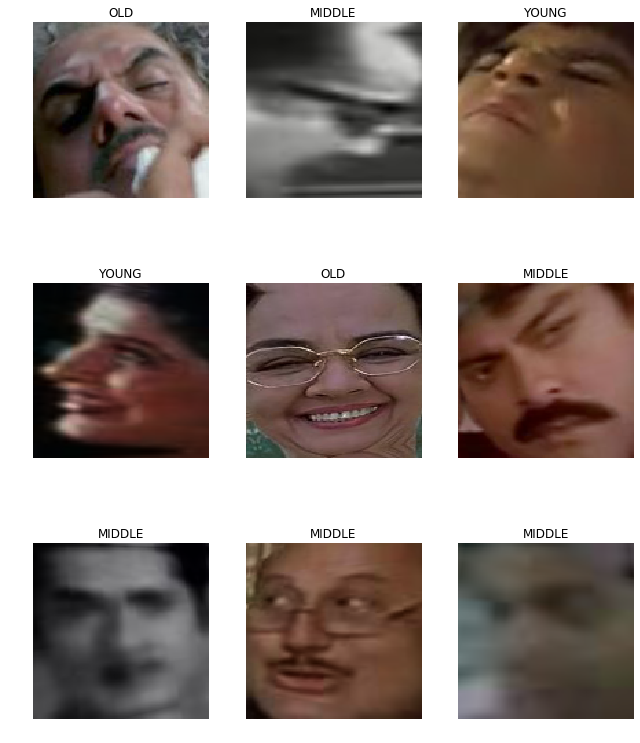

In [19]:
train_set.show_batch(rows=3, figsize=(9,11))

In [20]:
train_set.classes, train_set.c, len(train_set.train_ds), len(train_set.valid_ds)

(['MIDDLE', 'OLD', 'YOUNG'], 3, 17916, 1990)

In [21]:
learn = cnn_learner(train_set
                    , models.resnet152
                    , metrics=[error_rate
                             , accuracy
                              ]
                    , ps=0.5
                   )

In [22]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.45E-03


0.001445439770745928

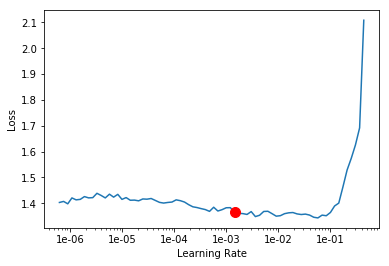

In [23]:
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr
min_grad_lr

In [24]:
learn.fit_one_cycle(6, slice(1e-3), wd=0.1)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.902008,0.775633,0.335176,0.664824,02:20
1,0.740886,0.682851,0.298492,0.701508,02:20
2,0.655375,0.605579,0.261809,0.738191,02:20
3,0.574648,0.567841,0.247739,0.752261,02:20
4,0.567398,0.529722,0.220603,0.779397,02:20
5,0.545610,0.527986,0.219095,0.780905,02:21


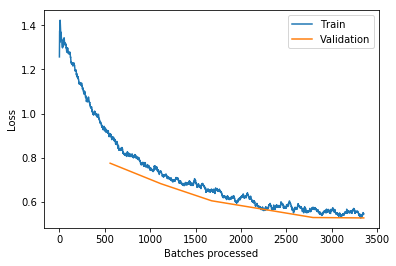

In [25]:
learn.recorder.plot_losses()

In [26]:
learn.save('stage-1-128-rn152')

fine tuning the whole model

In [27]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-05


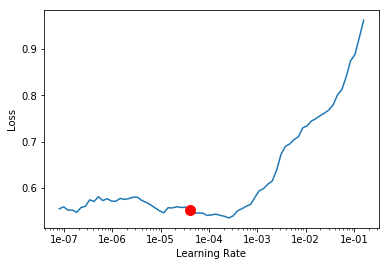

In [28]:
learn.lr_find(start_lr=1e-8)
learn.recorder.plot(suggestion=True)

In [29]:
learn.fit_one_cycle(10, slice(5e-6, 5e-5), wd=0.1)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.523737,0.512277,0.216080,0.783920,03:10
1,0.480916,0.451288,0.175377,0.824623,03:10
2,0.399965,0.383037,0.150754,0.849246,03:10
3,0.354621,0.340359,0.127638,0.872362,03:10
4,0.283912,0.306957,0.115075,0.884925,03:10
5,0.218398,0.300651,0.116583,0.883417,03:10
6,0.184893,0.283411,0.105528,0.894472,03:10
7,0.157384,0.269018,0.103015,0.896985,03:11
8,0.135390,0.279889,0.104020,0.895980,03:11
9,0.140366,0.268850,0.100000,0.900000,03:10


In [30]:
learn.save('stage-2-128-rn50')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.41E-09


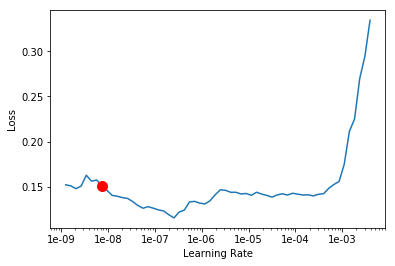

In [31]:
learn.lr_find(start_lr=1e-10)
learn.recorder.plot(suggestion=True)

In [32]:
learn.fit_one_cycle(10, slice(1e-8, 1e-7), wd=0.1) #0.839196

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.125183,0.277567,0.103518,0.896482,03:10
1,0.135996,0.277171,0.101005,0.898995,03:10
2,0.123585,0.281748,0.103518,0.896482,03:11
3,0.132585,0.278007,0.102010,0.897990,03:10
4,0.130187,0.285689,0.104020,0.895980,03:11
5,0.120416,0.273707,0.101508,0.898492,03:11
6,0.124911,0.269829,0.099497,0.900503,03:11
7,0.135028,0.270544,0.102010,0.897990,03:10
8,0.128655,0.266717,0.099497,0.900503,03:10
9,0.143711,0.281282,0.104020,0.895980,03:11


In [33]:
learn.save('stage-3-128-rn152')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07


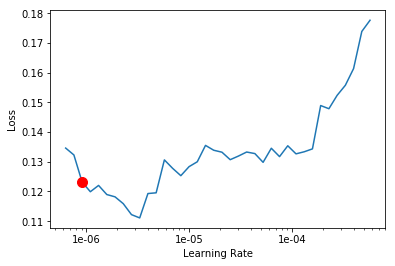

In [51]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [52]:
learn.fit_one_cycle(10, slice(7e-7, 4e-6), wd=0.1) #0.839196

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.126623,0.272423,0.101508,0.898492,03:11
1,0.124797,0.273716,0.098995,0.901005,03:11
2,0.124549,0.267647,0.103015,0.896985,03:11
3,0.122716,0.271087,0.098995,0.901005,03:11
4,0.115915,0.272276,0.098492,0.901508,03:11
5,0.105441,0.262191,0.095477,0.904523,03:11
6,0.114732,0.272924,0.102513,0.897487,03:11
7,0.101720,0.275353,0.098492,0.901508,03:11
8,0.100880,0.284082,0.101005,0.898995,03:11
9,0.109510,0.276822,0.100000,0.900000,03:11


In [53]:
learn.save('stage-4-128-rn152')

In [54]:
interp = ClassificationInterpretation.from_learner(learn)

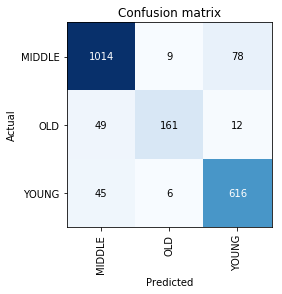

In [55]:
interp.plot_confusion_matrix()

In [56]:
interp.most_confused(min_val=2)

[('MIDDLE', 'YOUNG', 78),
 ('OLD', 'MIDDLE', 49),
 ('YOUNG', 'MIDDLE', 45),
 ('OLD', 'YOUNG', 12),
 ('MIDDLE', 'OLD', 9),
 ('YOUNG', 'OLD', 6)]

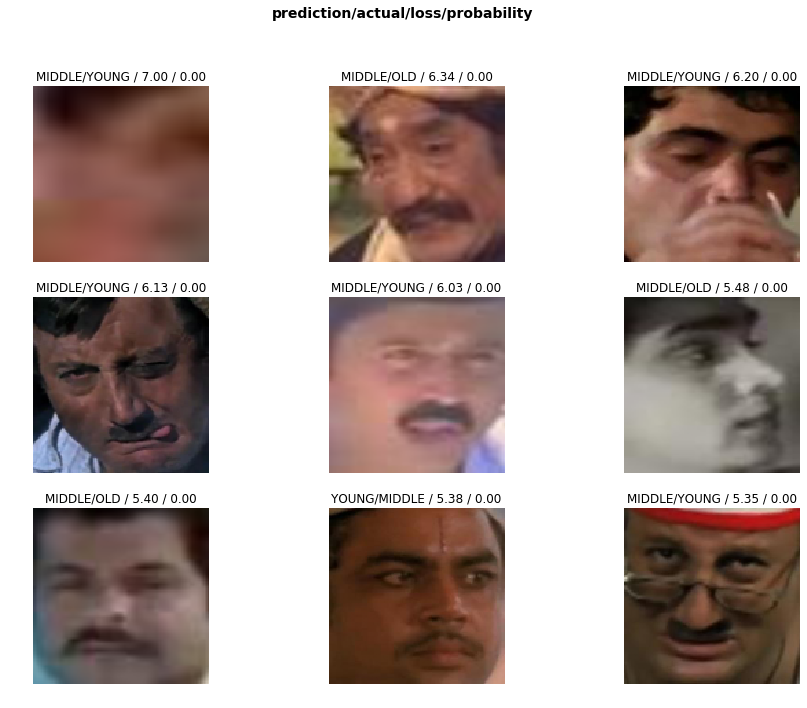

In [57]:
interp.plot_top_losses(9, figsize=(15,11), heatmap=False)

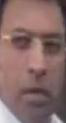

In [58]:
img = open_image(Path/'Test/19277.jpg')
img

In [59]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class, pred_idx, outputs

(Category YOUNG, tensor(2), tensor([0.3572, 0.1074, 0.5354]))

In [60]:
probs, _ = learn.get_preds(ds_type=DatasetType.Test)

In [61]:
probs

tensor([[8.9250e-01, 8.1443e-03, 9.9354e-02],
        [6.0942e-05, 1.2371e-04, 9.9982e-01],
        [3.5720e-01, 1.0736e-01, 5.3544e-01],
        ...,
        [9.8987e-01, 9.3589e-03, 7.6645e-04],
        [9.9922e-01, 2.5716e-04, 5.2260e-04],
        [4.5157e-03, 3.8434e-03, 9.9164e-01]])

In [62]:
final = [train_set.classes[i] for i in np.argmax(probs, axis=1)]

In [63]:
final[:5]

['MIDDLE', 'YOUNG', 'YOUNG', 'MIDDLE', 'MIDDLE']

In [64]:
submission['Class'] = final
submission['ID'] = test_df['ID']

In [65]:
submission.head(10)

,Class,ID
0,MIDDLE,25321.jpg
1,YOUNG,989.jpg
2,YOUNG,19277.jpg
3,MIDDLE,13093.jpg
4,MIDDLE,5367.jpg
5,MIDDLE,19851.jpg
6,YOUNG,10384.jpg
7,YOUNG,24567.jpg
8,MIDDLE,2029.jpg
9,MIDDLE,4956.jpg


In [66]:
file_timestamp = datetime.now().strftime('%m%d%Y_%H%M')
submission.to_csv(f'{Path}/Submission_RN152_{file_timestamp}.csv', index=False)